In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
from os import listdir
from os.path import join

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.io import loadmat
from scipy.stats import linregress, sem
from tqdm.notebook import tqdm

import rl

matplotlib = rl.plot_utils.set_mpl_defaults(matplotlib)

# Terminology

Terms used:

- Participants performed two **sessions**
    - that mapped to the two **conditions** (`High-Carb` and `High-Pro`).
- Within each session, participants performed two **blocks** of 100 trials of the task.
    - Within each block, there were **episodes**,
        - where the reward contingencies for the participants' **actions** remained the same.
        - In each trial, the reward contingencies are given by the trial's **state**.

# Load and inspect data

First, we load and preprocess the data. Note that the column coding the current `state` was bugged and had to be reconstructed from columns coding the participants' `action` (left or right key press) and a column coding whether this action was `correct` given the current state. This works fine, except for trials where participants failed to respond. In these trials, we cannot infer which state the trial was in.

In [3]:
DATA_DIR = join("private", "Carbs2_data_RL")
conditions_file = "0-session_conditions.xlsx"
physiological_file = "1-physiological_measures.xlsx"

In [4]:
def read_data(data_dir, physiological_file, conditions_file):
    """This function 
     1) reads, processes and combines all .mat files
        containing behavioural data from the prior experiment
        run in Soyoung's Lab and transforms them into a single
        pandas.DataFrame.
     2) reads and processes the physiological data
    
    Args:
        data_dir (str): Path to the data directory with folders for data from each condition.
        physiological_file (str): Filename of the file containing the physiological data. Assumed to be in `data_dir`.
        conditions_file (str): Filename of the file containing the mapping of sessions to conditions. Assumed to be in `data_dir`.
    
    Returns:
        Tuple of pandas.DataFrames: Behavioural data, physiological data
    """

    # Read conditions file
    conditions_map = {"High_Carb": "highcarb", "High_Pro": "highpro"}
    conditions = (
        pd.read_excel(join(data_dir, conditions_file))
        .rename(
            {"Sub_ID": "subject", "Session_1": "session1", "Session_2": "session2"},
            axis=1,
        )
        .replace(conditions_map)
    )

    # Read behavioural data
    columns = [
        "trial",  # 1-100
        "state",  # type reversal block 1, 2, 3 || FM: I think there's an error and this variable counts the number of reversals
        "trial_episode",  # trial count in episode 1 to min 10 and max 16
        "correct_response",  # 1 left side correct, 0 right side correct
        "_",  # response recorded: 1 button was pressed, 0 no button was pressed
        "a",  # pressed button 98 leftkey, 99 rightkey || FM: I think there's also 0s in this column, if no response was made?
        "r",  # feedback: 1 smiley, 0 frowny
        "correct",  # response correct: 1 yes, 0 no, 3 if both options were correct (50:50 states)
        "_",  # timestamp "scan0"
        "_",  # timestamp "exp0"
        "_",  # timestamp "stimulus onset"
        "rt",  # response time
        "_",  # timestamp "feedback onset"
        "_",  # timestamp "fixation onset"
        "_",  # intertrial interval
    ]

    # List all mat files
    matfiles = [
        file
        for file in listdir(join(data_dir))
        if file.endswith(".mat") and not file.startswith("exclude-")
    ]

    df = []
    for filename in matfiles:
        # Extract subject ID
        # (filenames look like this: "temp_acquisition_RL_05_session02_2_21032017_1217.mat")
        subject = int(filename[20:22])
        session = int(filename[30:32])
        block = int(filename[33:34]) - 1

        condition = conditions.loc[
            conditions["subject"] == subject, f"session{session}"
        ].values[0]

        # Load data of single subject and condition
        x = loadmat(join(data_dir, filename))
        df_sc = pd.DataFrame(x["data_matrix"], columns=columns)
        df_sc["condition"] = condition
        df_sc["subject"] = subject
        df_sc["session"] = session
        df_sc["block"] = block

        # Append to list of all dataframes
        df.append(df_sc)

    # Concatenate all dataframes
    df = pd.concat(df)

    # Reconstruct state variable (coding current reward probabilities, originally bugged in the data)
    df["state"] = np.where(
        df["a"] == 0,  # when no button was pressed
        np.nan,  # we can't infer the state
        np.where(
            df["correct"]
            == 3,  # otherwise, if both options are correct, we're in state 2
            2,
            np.where(
                (
                    (df["a"] == 98) & (df["correct"] == 1)
                )  # otherwise, if the participant answered left and that was correct
                | (
                    (df["a"] == 99) & (df["correct"] == 0)
                ),  # or the participant answered right and that was incorrect
                0,  # we're in state 1
                1,  # otherwise we're in state 2
            ),
        ),
    )

    # Reformat variables
    df["trial"] = (df["trial"] - 1).astype(np.int32)  # Make trial variable start with 0
    df["a"] = (df["a"] - 98).astype(
        np.int32
    )  # Recode from 98 = left 99 = right to 0 = left, 1 = right
    df.loc[df["a"] == -98, "a"] = np.nan
    df[
        "s"
    ] = 0  # this variable codes the agents' perceived state (which is always the same in this task)
    df["trial_episode"] = df["trial_episode"].astype(np.int32)

    bh = (
        df[
            [
                "subject",
                "session",
                "condition",
                "block",
                "trial",
                "trial_episode",
                "state",
                "s",
                "a",
                "r",
                "correct",
            ]
        ]
        .sort_values(["subject", "condition", "block", "trial"])
        .reset_index(drop=True)
    )

    # Physiological data
    ph = pd.read_excel(join(data_dir, physiological_file))

    ph.rename(
        {
            "Sub_ID": "subject",
            "AUC_Tyr_HighCarb": "tyr-highcarb",
            "AUC_Tyr_HighPro": "tyr-highpro",
            "AUC_Trp_HighCarb": "trp-highcarb",
            "AUC_Trp_HighPro": "trp-highpro",
        },
        axis=1,
        inplace=True,
    )
    # Strip subject column from leading 'S'
    #     ph["subject"] = ph["subject"].apply(lambda x: int(x[1:]))

    ph = (
        pd.wide_to_long(
            ph,
            stubnames=["tyr", "trp"],
            i="subject",
            j="condition",
            sep="-",
            suffix="\\w+",
        )
        .sort_values(["subject", "condition"])
        .reset_index()
    )

    return (bh, ph)

In [5]:
bh, ph = read_data(
    DATA_DIR, physiological_file=physiological_file, conditions_file=conditions_file
)

## Inspect data

Here, I inspect the data for completeness and whether it looks okay superficially.

### Behavioural data

In [6]:
bh.head()

,subject,session,condition,block,trial,trial_episode,state,s,a,r,correct
0,1,1,highcarb,0,0,1,0.0,0,1.0,0.0,0.0
1,1,1,highcarb,0,1,2,0.0,0,0.0,1.0,1.0
2,1,1,highcarb,0,2,3,0.0,0,0.0,1.0,1.0
3,1,1,highcarb,0,3,4,0.0,0,0.0,0.0,1.0
4,1,1,highcarb,0,4,5,0.0,0,0.0,1.0,1.0


#### Did inferring the state work?

There still has to be a bug, and I'm 90% sure it's in the original data. Let's look at the last three trials from subject 1, session 1, block 1, and focus on the columns

- `trial_episode`: Counting numbers of trials in current episode (taken from original data, without preprocessing)
- `state`: Indicating current state / reward scheme (reconstructed from columns `a` and `correct`, which both, were not preprocessed before this)
- `a`: Current action (response) (coded from `{0: no response, 98: left, 99: right}` to `{np.nan: no response, 0: left, 1: right}`
- `correct`: Correctness of current response (`{0: incorrect, 1: correct}`, not preprocessed)

In [7]:
bh.loc[
    (bh["subject"] == 1) & (bh["condition"] == "highcarb") & (bh["block"] == 0)
].tail(3)[["trial", "trial_episode", "a", "r", "correct", "state"]]

,trial,trial_episode,a,r,correct,state
97,97,1,1.0,0.0,0.0,0.0
98,98,2,1.0,0.0,0.0,0.0
99,99,3,0.0,1.0,0.0,1.0


In the last trial, we see that the `state`, which was directly inferred from response `a` and correctness `correct`, differs from the state in the previous two trials, even though the `trial_episode` counter advances.

It's obvious, that, if the state remained constant (as indicated by the `trial_episode` variable), then either action `0` or action `1` must be correct (unless we're in the 50:50 state, but then `correct` would have the value `3`), but the data marks them both incorrect.

This should not be the case. I think either the `correct` column, or the `a` column in the original data must be flawed.

#### Missing data

In [8]:
n_subjects = len(bh["subject"].unique())
n_sessions = 2
n_blocks = 2
n_trials = 100
print(f"Data from {n_subjects} participants included.")
length_target = n_subjects * n_sessions * n_blocks * n_trials
print(f"Behavioural data should have length {length_target}, has length {len(bh)}.")

Data from 31 participants included.
Behavioural data should have length 12400, has length 12000.


In [9]:
bh["subject"].value_counts().sort_values()[:3]

13    200
23    200
8     400
Name: subject, dtype: int64

In [10]:
bh["subject"].value_counts().sort_values()[-2:]

19    400
4     400
Name: subject, dtype: int64

In [11]:
bh.loc[bh["subject"] == 13, "condition"].unique()

array(['highpro'], dtype=object)

In [12]:
bh.loc[bh["subject"] == 23, "condition"].unique()

array(['highpro'], dtype=object)

There's a total of 400 trials missing:

- Subject 13 is missing in `HighCarb` condition.
- Subject 23 is missing in `HighCarb` condition.

So for the final analyses the effective sample size is 29.

In [13]:
# Compute number of missing responses per subject and condition
missing_response_count = (
    pd.isnull(bh["a"])
    .groupby([bh["subject"], bh["condition"]])
    .sum()
    .sort_values(ascending=False)
)
missing_response_count.head(20)

subject  condition
4        highcarb     72
31       highpro      21
4        highpro      21
21       highcarb     16
23       highpro      15
2        highpro      13
17       highcarb     12
21       highpro      12
14       highpro      11
24       highcarb     11
30       highcarb      9
26       highcarb      6
17       highpro       5
7        highcarb      5
15       highpro       4
25       highcarb      4
24       highpro       4
13       highpro       3
29       highpro       3
28       highpro       3
Name: a, dtype: int64

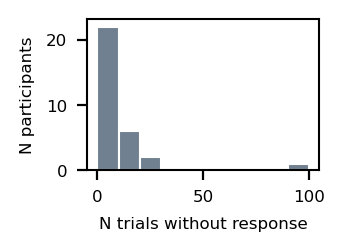

In [14]:
fig, ax = plt.subplots(figsize=(1.5, 1), dpi=200)
ax.hist(
    missing_response_count.groupby("subject").sum().values,
    edgecolor="white",
    bins=np.arange(0, 101, 10),
)
ax.set_ylabel("N participants")
ax.set_xlabel("N trials without response");

- There are some subjects with a considerable number of trials without response (e.g., subject 4 misses 93 trials in total).
- Most subjects have at least one missing response.

#### Task difficulty

Next, I look for indications, that the task was too difficult for participants (i.e., that the reversals occured too early, and participants were not able to learn the correct response in each episode, before it was switched).

I will look at two measures, which should yield very similar results:
1. The average number of trials within each episode (numbers close to the maximum of 16 trials indicate that reversals occured before participants achieved a cumulated accuracy of 70% in the episode)
2. The average accuracy at the end of each episode (values lower than 70% indicate that the state changed before participants learned the reward contingencies)

In [15]:
# summarize data to the level of episodes
# first, remove trials with missing responses, as states could not be identified there
bh_nomissing = bh.loc[~pd.isnull(bh["a"])].copy()


# also mark trials at the end of the block. Here, phases are cut off, independent of any other criteria
def mark_last(s):
    """This helper function marks the last item of a pandas.groupby operation.
    
    Args:
        s (pandas.Series): A series of the groupby result.
    Returns:
        pandas.Series: A series of the same length as `s`, where the last entry is `True` and all other entries are `False`.
    """

    is_last = pd.Series(False, index=s.index, name="is_last")
    is_last.iloc[-1] = True
    return is_last


bh_nomissing["block_end"] = bh_nomissing.groupby(["subject", "condition", "block"])[
    "trial"
].apply(mark_last)

# Create a running index of episodes within each block
def index_episodes(s):
    idx = (s != s.shift()).cumsum()
    return idx


bh_nomissing["episode"] = bh_nomissing.groupby(["subject", "condition", "block"])[
    "state"
].apply(index_episodes)

# Compute whether participants' responses were correct
bh_nomissing["correct"] = np.where(
    ((bh_nomissing["state"] == 0) & (bh_nomissing["a"] == 0))
    | ((bh_nomissing["state"] == 1) & (bh_nomissing["a"] == 1)),
    1,
    0,
)

# Calculate cumulative accuracy within each episode
def cummean(s):
    """Calculate cumulative mean of a series.
    To be used with `pandas.groupby`."""
    cm = s.cumsum() / (np.arange(len(s)) + 1)
    return cm


bh_nomissing["episode_accuracy"] = (
    bh_nomissing.groupby(["subject", "condition", "block", "episode"])["correct"]
    .apply(cummean)
    .round(2)
)

# for each episode, compute number of trials and final accuracy
# excluding episodes that were cut short by the end of the block
episodes = (
    bh_nomissing.groupby(  # .loc[~bh_nomissing["block_end"]]  # exclude episodes at end of block
        ["subject", "condition", "block", "episode"]
    )
    .agg(
        {
            "correct": "mean",
            "state": np.nanmean,
            "trial_episode": len,
            "block_end": "max",
        }
    )
    .rename({"last_trial": "block_end", "trial_episode": "n_trials"}, axis=1)
)

Let's inspect the episodes first:

In [16]:
episodes.head(10)

correct  state  n_trials  block_end
subject condition block episode                                      
1       highcarb  0     1        0.900000    0.0        10      False
                        2        0.000000    2.0        16      False
                        3        0.687500    1.0        16      False
                        4        0.875000    0.0        16      False
                        5        0.846154    1.0        13      False
                        6        0.000000    2.0        16      False
                        7        1.000000    1.0        10      False
                        8        0.000000    0.0         2      False
                        9        0.000000    1.0         1       True
                  1     1        0.750000    1.0        16      False

As reported above, there is still some error with respect to the coding of the states (here indicated by the episode with only two trials, that is *not* at the block end).

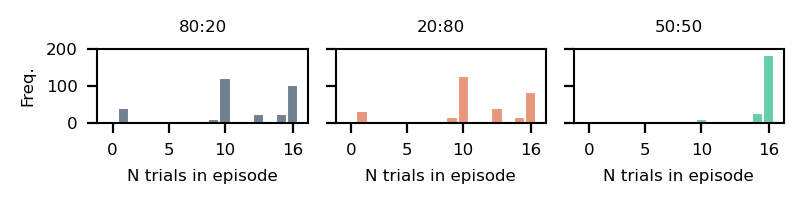

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(4, 1), dpi=200, sharey="row")

for ax, state, label in zip(axs, [0, 1, 2], ["80:20", "20:80", "50:50"]):
    ax.hist(
        episodes.loc[episodes["state"] == state, "n_trials"],
        edgecolor="white",
        color=f"C{state}",
        bins=np.arange(-1, 17) + 0.5,
    )  # first bin -0.5 to 0.5, last bin 15.5 - 16.5
    ax.set_xticks([0, 5, 10, 16])
    ax.set_title(label)
    ax.set_xlabel("N trials in episode")

axs[0].set_ylim(0, 200)
axs[0].set_ylabel("Freq.")

fig.tight_layout()

- Some reversals look too short (less than 10 trials) or too long (more than 16 trials), which is directly related to the problem concerning the coding of states.
- Apart from that, for states 0 (80:20) and 1 (20:80), the distributions of trial counts looks very bimodal:
    - In some episodes, participants reached the required accuracy very fast
    - In other episodes, they did not achieve the required accuracy within 16 trials
    - This could be the result from participants choosing one alternative early and sticking to it, irrespective of the outcome.
        - Might indicate, that a good model of participants' behaviour should include choice stickiness (a.k.a. perseveration)
- The 50:50 states are almost exclusively 16 trials long, because there, all responses have been coded as "incorrect" (even though actually both were equally correct). This is a design choice.
    - However, it's very important to include this, when modeling the task itself!
        - If I simulate data from an agent interacting with the task, and compare it with observed data, I need the task to behave exactly as it did in the experiment.

In [18]:
# Compute subject-wise mean accuracy and numbers of trials in episodes with states 0 and 1
# excluding blocks with less than 10 trials, because they should not have happened
episodes_subject_summary = (
    episodes.loc[
        ~episodes["block_end"] & (episodes["state"] != 2) & (episodes["n_trials"] > 9)
    ]
    .groupby("subject")
    .agg({"correct": "mean", "n_trials": "mean"})
)
episodes_subject_summary.head()

,correct,n_trials
subject,,
1,0.799170,13.647059
2,0.787399,12.631579
3,0.832740,12.400000
4,0.534133,14.357143
5,0.842788,12.100000


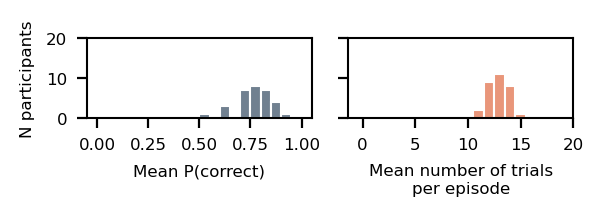

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(3, 1), dpi=200, sharey="row")

axs[0].hist(
    episodes_subject_summary["correct"], bins=np.linspace(0, 1, 21), edgecolor="white"
)
axs[0].set_xlabel("Mean P(correct)")
axs[0].set_xticks(np.arange(0, 1.1, 0.25))

axs[1].hist(
    episodes_subject_summary["n_trials"],
    bins=np.arange(-1, 17) + 0.5,
    edgecolor="white",
    color="C1",
)
axs[1].set_xlabel("Mean number of trials\nper episode")
axs[1].set_xticks(np.arange(0, 21, 5))

axs[0].set_ylabel("N participants")
axs[0].set_ylim(0, 20)

fig.tight_layout()

Looking at subject-wise average accuracies and number of trials per episode:

- More than half of subjects have mean accuracies above 70%
    - This might indicate, that subjects were very good at consistently choosing the correct option with only a few number of trials (e.g., choosing correct 9 times out of 10, finishing the episode with 90% accuracy)

In [20]:
episodes_subject_summary.agg(["mean", "sem"], axis=0)

,correct,n_trials
mean,0.772231,12.917629
sem,0.014938,0.148540


These average values do not give an indication that the task was too hard.

- However, as argued above, these averages might not be too representative, if the true distribution is bimodal (very short episodes, with high accuracy, and very long episodes, with low accuracy)

### Physiological data

In [21]:
ph_desc = ph.groupby("condition")[["tyr", "trp"]].agg([np.mean, sem])
ph_desc

tyr                 trp          
               mean       sem      mean       sem
condition                                        
highcarb   0.606548  0.015406  0.708710  0.016088
highpro    0.628194  0.014639  0.583161  0.015079

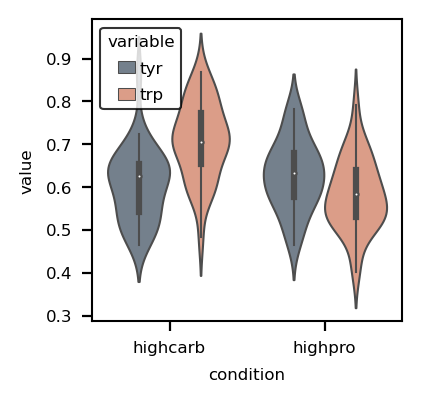

In [22]:
ph_longer = ph.melt(id_vars=["subject", "condition"], value_vars=["tyr", "trp"])
fig, ax = plt.subplots(figsize=(2, 2), dpi=200)
ax = sns.violinplot(
    x="condition", y="value", hue="variable", data=ph_longer, kind="violin", ax=ax
)

Check out differences between conditions:

In [23]:
ph_wide = ph.pivot(index="subject", columns="condition")

for var in ["tyr", "trp"]:
    diff = ph_wide[var]["highcarb"] - ph_wide[var]["highpro"]
    ph_wide[(var, "diff")] = diff
ph_wide.head()

tyr              trp            tyr    trp
condition highcarb highpro highcarb highpro   diff   diff
subject                                                  
1            0.518   0.487    0.688   0.529  0.031  0.159
2            0.635   0.593    0.838   0.658  0.042  0.180
3            0.587   0.619    0.823   0.791 -0.032  0.032
4            0.572   0.632    0.603   0.531 -0.060  0.072
5            0.519   0.509    0.696   0.516  0.010  0.180

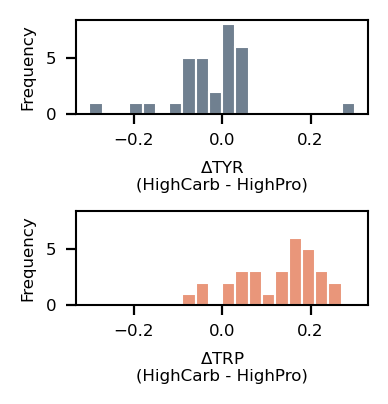

In [24]:
bins = np.linspace(-0.3, 0.3, 21)
fig, axs = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(2, 2), dpi=200)
for i, var in enumerate(["tyr", "trp"]):
    axs[i].hist(ph_wide[(var, "diff")], bins=bins, color=f"C{i}", edgecolor="white")
    axs[i].set_xlabel("$\Delta$" + var.upper() + "\n(HighCarb - HighPro)")
    axs[i].set_ylabel("Frequency")
    axs[i].xaxis.set_tick_params(which="both", labelbottom=True)
fig.tight_layout()

In [25]:
print(
    f"{(ph_wide[('tyr', 'diff')] > 0).sum()} participants have higher TYR in HighCarb."
)

15 participants have higher TYR in HighCarb.


In [26]:
print(
    f"{(ph_wide[('trp', 'diff')] > 0).sum()} participants have higher TRP in HighCarb."
)

28 participants have higher TRP in HighCarb.


- Tyrosene is generally higher in `HighPro` condition
- Tryptophane is generally in `HighCarb`
- There is substantial variability between subjects
    - For some subjects, the difference is *not* as predicted
        - Particularly true for Tyrosene, which is higher in `HighCarb` for 15/31 (48%) participants

# Fit reinforcement learning model

## Prepare estimation

In [27]:
# Initialize task variables
task_vars = rl.task.TaskVars(n_trials=100, n_blocks=2, n_options=2, n_states=1)

# Initialize estimation variables
# Define parameters to estimate
parameters = ["alpha_pos", "alpha_neg", "beta"]

# Set boundaries (used to initialize and constrain estimation)
bounds = {"alpha_pos": (0, 1), "alpha_neg": (0, 1), "beta": (0.01, 100)}

# Note, that we also need to specify the agent_class (i.e., the agent "model")
est_vars = rl.estimation.EstimationVars(
    task_vars,
    agent_class=rl.agent.DualLearningRateAgent,
    parameters=parameters,
    bounds=bounds,
    n_sp=5,
)

# Initialize estimation instance
est = rl.estimation.Estimation(est_vars)

## Fit `HighCarb` and `HighPro` conditions separately

In [28]:
# Initialize agent_vars
agent_vars = rl.agent.AgentVars(
    variant="r"
)  # n.b. we're using the "r" variant that distinguishes learning rates based on reward, not on the RPE

results = {}

# Cycle over conditions
conditions = ["highcarb", "highpro"]
for condition in conditions:
    print(f"Estimating parameters for '{condition}' condition.")

    results[condition] = []

    # Cycle over subjects with data in that condition
    for subject in tqdm(bh.loc[bh["condition"] == condition, "subject"].unique()):
        print(f"  Subject {subject}")

        # Subject DataFrame
        df_s = bh.loc[(bh["subject"] == subject) & (bh["condition"] == condition)]

        # Now we can estimate the maximum likelihood parameters
        result = est.estimate(data=df_s, agent_vars=agent_vars, seed=1)

        # Save results to DataFrame
        result_df = pd.DataFrame(
            dict(
                subject=subject,
                nll=result[0],
                bic=result[1],
                alpha_pos=result[2][0],
                alpha_neg=result[2][1],
                beta=result[2][2],
            ),
            index=[subject],
        )
        results[condition].append(result_df)

    # Concatenate results for this condition, across subjects
    results[condition] = (
        pd.concat(results[condition]).sort_values("subject").reset_index(drop=True)
    )
    results[condition]["condition"] = condition

# Concatenate results across conditions
results = pd.concat([results[condition] for condition in conditions]).reset_index(
    drop=True
)
results.to_csv("parklab_RWpn-estimates.csv")

Estimating parameters for 'highcarb' condition.


  Subject 1
  Subject 2
  Subject 3
  Subject 4
  Subject 5
  Subject 6
  Subject 7
  Subject 8
  Subject 9
  Subject 10
  Subject 11
  Subject 12
  Subject 14
  Subject 15
  Subject 16
  Subject 17
  Subject 18
  Subject 19
  Subject 20
  Subject 21
  Subject 22
  Subject 24
  Subject 25
  Subject 26
  Subject 27
  Subject 28
  Subject 29
  Subject 30
  Subject 31

Estimating parameters for 'highpro' condition.


  Subject 1
  Subject 2
  Subject 3
  Subject 4
  Subject 5
  Subject 6
  Subject 7
  Subject 8
  Subject 9
  Subject 10
  Subject 11
  Subject 12
  Subject 13
  Subject 14
  Subject 15
  Subject 16
  Subject 17
  Subject 18
  Subject 19
  Subject 20
  Subject 21
  Subject 22
  Subject 23
  Subject 24
  Subject 25
  Subject 26
  Subject 27
  Subject 28
  Subject 29
  Subject 30
  Subject 31



# Parameter recovery of the estimated parameters with the task used

to be done

# Analysis of parameter estimates and physiological measures

In [29]:
# join DataFrames
df = (
    results.merge(ph, on=["subject", "condition"], how="outer")
    .sort_values(["subject", "condition"])
    .reset_index(drop=True)[
        [
            "subject",
            "condition",
            "tyr",
            "trp",
            "nll",
            "bic",
            "alpha_pos",
            "alpha_neg",
            "beta",
        ]
    ]
)
df.head()

,subject,condition,tyr,trp,nll,bic,alpha_pos,alpha_neg,beta
0,1,highcarb,0.518,0.688,58.204493,132.303939,0.024623,0.696256,100.000000
1,1,highpro,0.487,0.529,47.103290,110.101532,0.341133,0.712781,12.456664
2,2,highcarb,0.635,0.838,48.861595,113.618143,0.169795,0.957970,100.000000
3,2,highpro,0.593,0.658,87.969162,191.833276,1.000000,0.693462,2.489275
4,3,highcarb,0.587,0.823,55.780248,127.455447,0.419144,0.749337,9.396764


## Correlation of parameters and physiological measures across conditions

In [30]:
def pairplot(df, color=None):
    """This function makes a plot of all pairs
    of variables in the dataframe and runs simple
    linear regressions.
    
    Args:
        df (pandas.DataFrame): A dataframe with all variables of interest.
        color (str, optional): Color to use for the plot. Defaults to 'C0'
    
    Returns:
        matplotlib.figure, numpy.array of matplotlib.axes
    """
    if color is None:
        color = "C0"

    # Count variables
    vars = df.columns
    nVars = len(vars)

    # Make a figure with some axes
    fig, axs = plt.subplots(
        nVars, nVars, figsize=(nVars, 4 / 5 * nVars), dpi=200, sharex="col",
    )

    # Cycle over all variables across rows
    for i, var_y in enumerate(vars):

        # and columns
        for j, var_x in enumerate(vars):
            ax = axs[i, j]

            # Switch off upper right triangle
            if j > i:
                ax.axis("off")

            # Make a histogram on diagonal
            elif var_x == var_y:
                ax.hist(df[var_x], edgecolor="white", color=color)
                ax.set_title(var_x)

            # Otherwise make a regression plot
            else:
                # Scatter plot
                x = df[var_x].values
                y = df[var_y].values
                ax.plot(x, y, "o", markeredgewidth=0.3, color=color)

                # Run linear regression
                b, a, r, p, _ = linregress(x=x, y=y)

                if p < 0.05:
                    pstr = "*"
                elif p < 0.01:
                    pstr = "**"
                elif p < 0.001:
                    pstr = "***"
                else:
                    pstr = ", n.s."

                # Print linear regression results
                print(
                    f"{var_y} ~ {var_x}\n  b={b:.2f}, a={a:.2f}, r={r:.2f}, p={p:.2f}{pstr}\n"
                )

                # Plot regression line
                xs = np.linspace(x.min(), x.max(), 100)
                ax.plot(xs, a + b * xs, color="black")

                # Add annotation with linear regression results
                ax.annotate(
                    f"b={b:.2f}, a={a:.2f}\nr={r:.2f}, p={p:.2f}",
                    (0.95, 0.05),
                    ha="right",
                    va="bottom",
                    xycoords="axes fraction",
                    fontsize="xx-small",
                )

            # Add x- and y-labels to the outer axes
            if i == (nVars - 1):
                ax.set_xlabel(var_x)
            if j == 0:
                ax.set_ylabel(var_y)
            if i == j:
                ax.set_ylabel("Frequency")

    fig.tight_layout()

    return fig, axs

trp ~ tyr
  b=0.31, a=0.45, r=0.25, p=0.06, n.s.

alpha_pos ~ tyr
  b=-0.26, a=0.85, r=-0.07, p=0.61, n.s.

alpha_pos ~ trp
  b=-0.84, a=1.22, r=-0.26, p=0.04*

alpha_neg ~ tyr
  b=0.02, a=0.77, r=0.01, p=0.94, n.s.

alpha_neg ~ trp
  b=0.16, a=0.68, r=0.09, p=0.48, n.s.

alpha_neg ~ alpha_pos
  b=0.01, a=0.78, r=0.03, p=0.85, n.s.

beta ~ tyr
  b=-58.46, a=61.57, r=-0.13, p=0.33, n.s.

beta ~ trp
  b=-46.68, a=55.45, r=-0.13, p=0.33, n.s.

beta ~ alpha_pos
  b=-41.11, a=53.79, r=-0.35, p=0.01*

beta ~ alpha_neg
  b=54.35, a=-17.16, r=0.25, p=0.05, n.s.



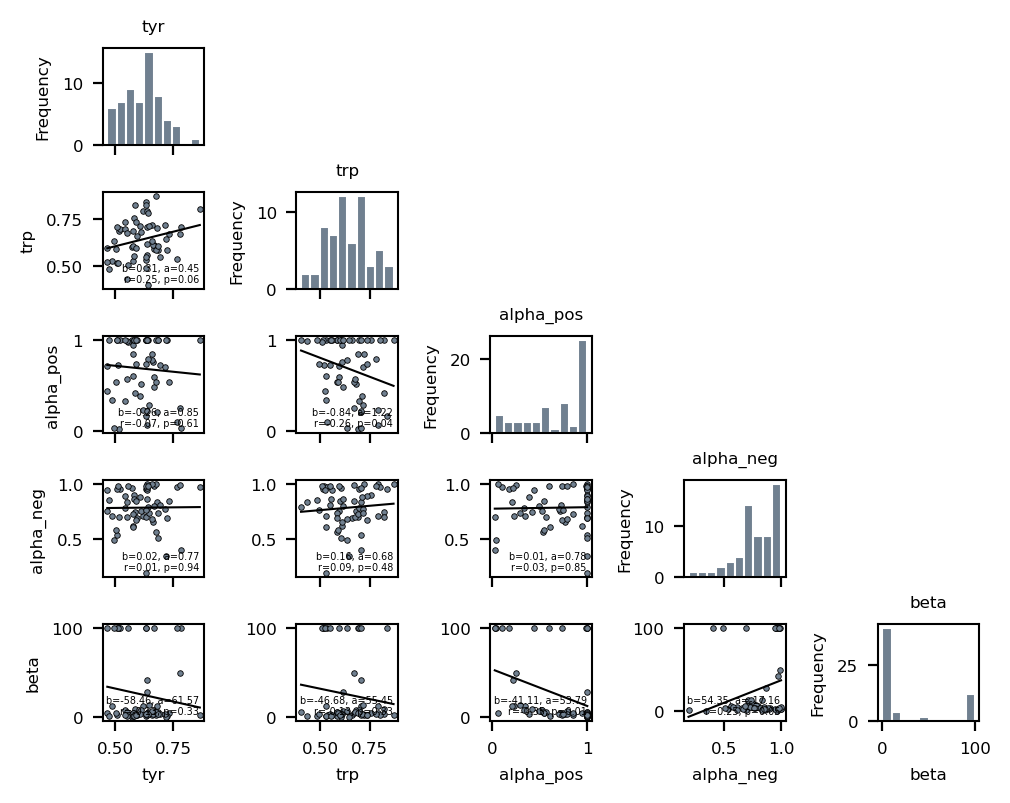

In [31]:
pairplot(df[["tyr", "trp", "alpha_pos", "alpha_neg", "beta"]].dropna(), color="C0");

## Correlation of learning rates and physiological measures, within each condition

'highcarb' condition
trp ~ tyr
  b=0.44, a=0.44, r=0.43, p=0.02*

alpha_pos ~ tyr
  b=0.43, a=0.38, r=0.11, p=0.58, n.s.

alpha_pos ~ trp
  b=-0.33, a=0.88, r=-0.08, p=0.67, n.s.

alpha_neg ~ tyr
  b=0.70, a=0.39, r=0.42, p=0.02*

alpha_neg ~ trp
  b=0.57, a=0.41, r=0.35, p=0.07, n.s.

alpha_neg ~ alpha_pos
  b=0.09, a=0.76, r=0.21, p=0.29, n.s.

beta ~ tyr
  b=-98.67, a=79.81, r=-0.26, p=0.18, n.s.

beta ~ trp
  b=14.77, a=9.84, r=0.04, p=0.84, n.s.

beta ~ alpha_pos
  b=-43.97, a=48.53, r=-0.46, p=0.01*

beta ~ alpha_neg
  b=-16.27, a=33.44, r=-0.07, p=0.71, n.s.



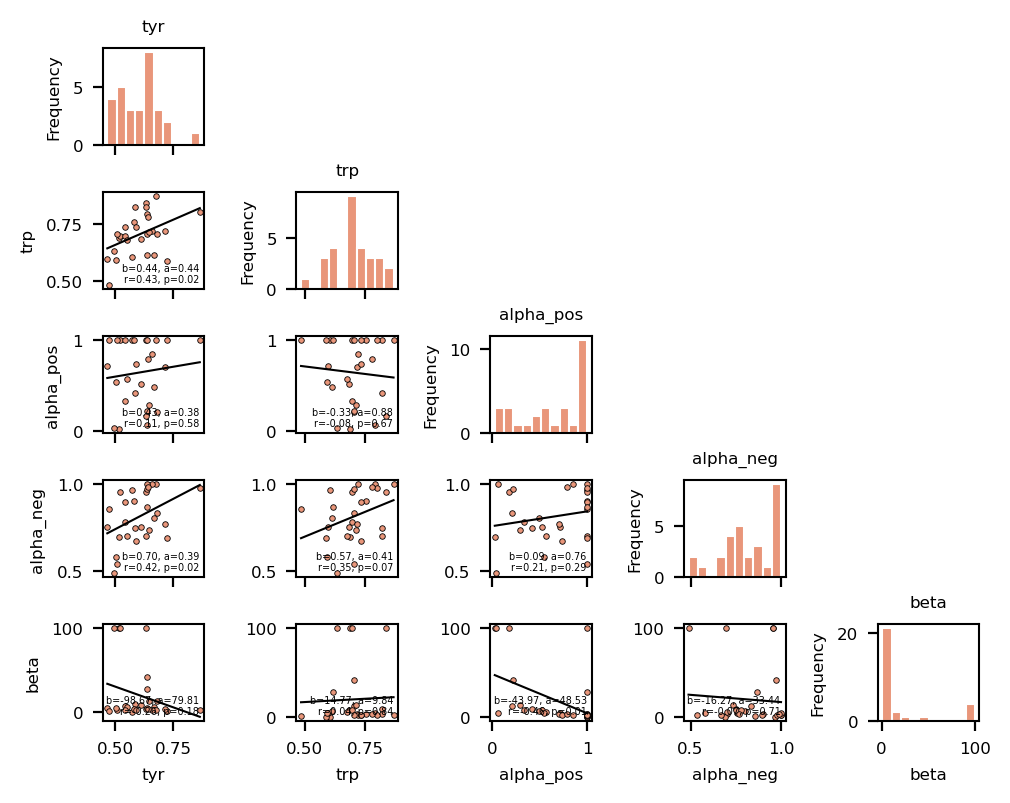

'highpro' condition
trp ~ tyr
  b=0.39, a=0.34, r=0.38, p=0.03*

alpha_pos ~ tyr
  b=-1.19, a=1.47, r=-0.32, p=0.08, n.s.

alpha_pos ~ trp
  b=-1.49, a=1.60, r=-0.41, p=0.02*

alpha_neg ~ tyr
  b=-0.62, a=1.15, r=-0.25, p=0.18, n.s.

alpha_neg ~ trp
  b=-0.56, a=1.09, r=-0.23, p=0.22, n.s.

alpha_neg ~ alpha_pos
  b=-0.05, a=0.80, r=-0.08, p=0.69, n.s.

beta ~ tyr
  b=-36.06, a=53.16, r=-0.07, p=0.71, n.s.

beta ~ trp
  b=-71.01, a=71.92, r=-0.14, p=0.45, n.s.

beta ~ alpha_pos
  b=-43.73, a=62.36, r=-0.32, p=0.08, n.s.

beta ~ alpha_neg
  b=96.35, a=-42.70, r=0.47, p=0.01*



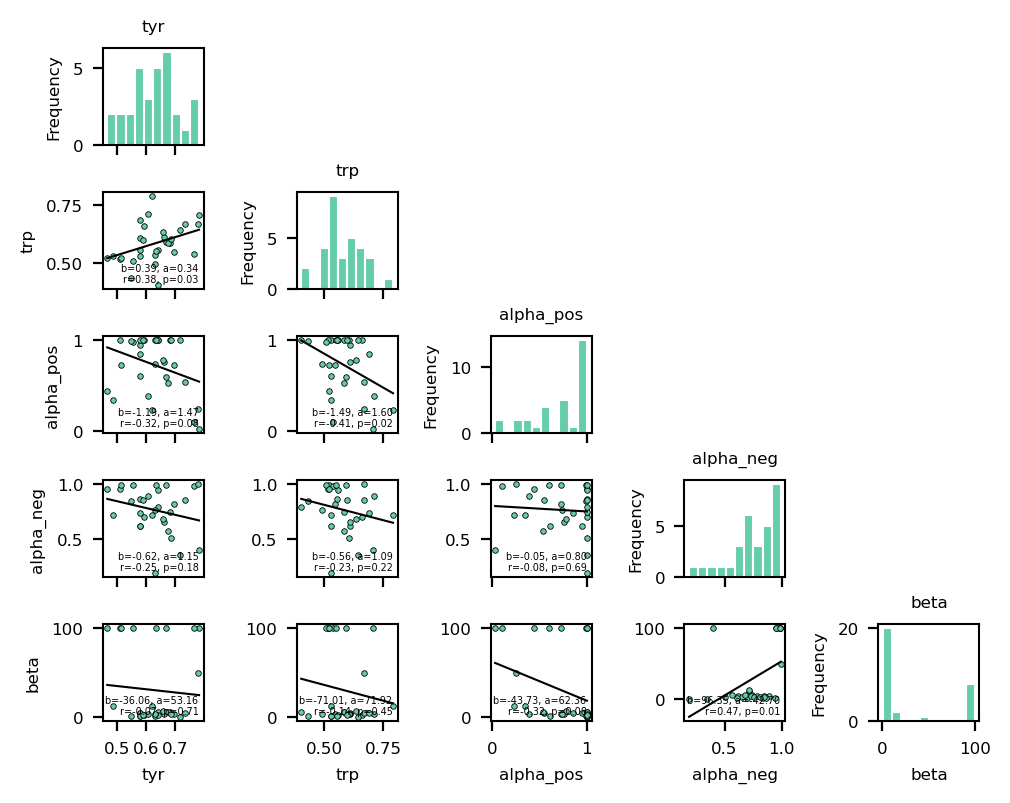

In [32]:
for c, condition in enumerate(["highcarb", "highpro"]):
    print(f"'{condition}' condition")
    df_c = df.loc[df["condition"] == condition]
    pairplot(
        df_c[["tyr", "trp", "alpha_pos", "alpha_neg", "beta"]].dropna(), color=f"C{c+1}"
    )
    plt.show()

## Correlation of change in physiological measures and change in learning rates

In [33]:
# Make wide dataframe with differences between conditions
df_wide = df.pivot(
    index="subject",
    columns="condition",
    values=["tyr", "trp", "alpha_pos", "alpha_neg"],
).reset_index()

# compute differences
for var in ["tyr", "trp", "alpha_pos", "alpha_neg"]:
    df_wide[(f"d_{var}")] = df_wide[(var, "highcarb")] - df_wide[(var, "highpro")]

df_wide = df_wide[["subject", "d_tyr", "d_trp", "d_alpha_pos", "d_alpha_neg"]]

# Remove multiindex
df_wide.columns = df_wide.columns.droplevel(1)

df_wide.head()

,subject,d_tyr,d_trp,d_alpha_pos,d_alpha_neg
0,1,0.031,0.159,-0.316509,-0.016525
1,2,0.042,0.180,-0.830205,0.264508
2,3,-0.032,0.032,0.188648,0.038945
3,4,-0.060,0.072,0.000000,0.778597
4,5,0.010,0.180,0.000000,0.001436


d_trp ~ d_tyr
  b=0.58, a=0.13, r=0.62, p=0.00*

d_alpha_pos ~ d_tyr
  b=-0.87, a=-0.09, r=-0.22, p=0.26, n.s.

d_alpha_pos ~ d_trp
  b=-0.47, a=-0.02, r=-0.11, p=0.57, n.s.

d_alpha_neg ~ d_tyr
  b=0.10, a=0.05, r=0.04, p=0.84, n.s.

d_alpha_neg ~ d_trp
  b=-0.23, a=0.07, r=-0.09, p=0.66, n.s.

d_alpha_neg ~ d_alpha_pos
  b=-0.10, a=0.04, r=-0.15, p=0.42, n.s.



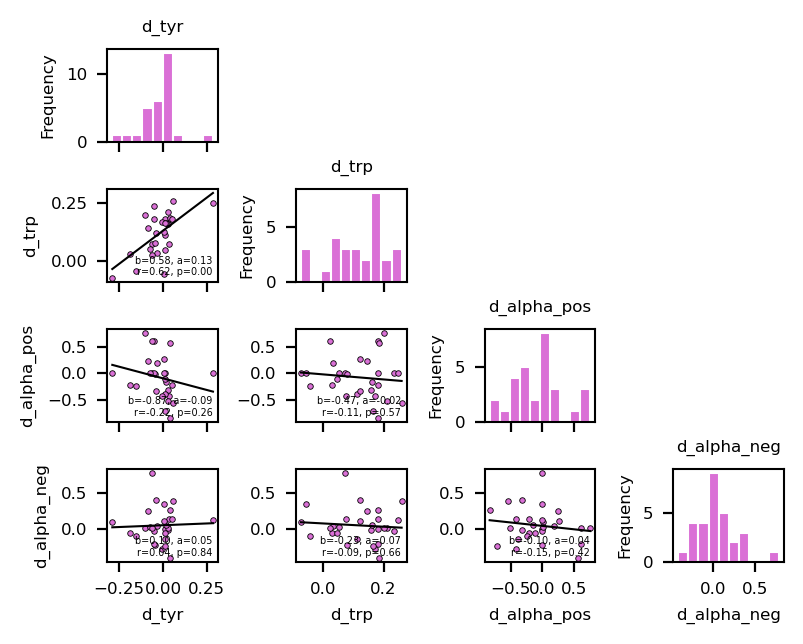

In [34]:
pairplot(df_wide[["d_tyr", "d_trp", "d_alpha_pos", "d_alpha_neg"]].dropna(), color="C4");